<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#To-critical-point" data-toc-modified-id="To-critical-point-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>To critical point</a></span><ul class="toc-item"><li><span><a href="#Visualise-all-the-datapoints" data-toc-modified-id="Visualise-all-the-datapoints-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Visualise all the datapoints</a></span></li><li><span><a href="#Rerun-DB-optimisations-for-single-points" data-toc-modified-id="Rerun-DB-optimisations-for-single-points-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Rerun DB optimisations for single points</a></span></li><li><span><a href="#CRAB-optimisation-for-single-points" data-toc-modified-id="CRAB-optimisation-for-single-points-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>CRAB optimisation for single points</a></span></li><li><span><a href="#Generate-plots-for-paper" data-toc-modified-id="Generate-plots-for-paper-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Generate plots for paper</a></span><ul class="toc-item"><li><span><a href="#Downsampling-data" data-toc-modified-id="Downsampling-data-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Downsampling data</a></span></li></ul></li></ul></li><li><span><a href="#Crossing-critical-point" data-toc-modified-id="Crossing-critical-point-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Crossing critical point</a></span></li><li><span><a href="#CRAB-variable-endpoints" data-toc-modified-id="CRAB-variable-endpoints-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>CRAB variable endpoints</a></span></li><li><span><a href="#Misc-code-snippets" data-toc-modified-id="Misc-code-snippets-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Misc code snippets</a></span></li></ul></div>

# Imports

In [474]:
import datetime
import logging
import os
import pickle
import sys
import time
import functools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express
import plotly.io
plotly.io.templates.default = "plotly_white"
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()
import progressbar
import qutip
import scipy
import seaborn as sns

if './src/' not in sys.path:
    sys.path.append('./src/')
import rabi_model
import lmg_model
import lz_model
import optimization
import protocol_ansatz
import hamiltonians
import utils
from utils import ground_state

sns.set()

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# To critical point

## Visualise all the datapoints

Note that the datasets `lz_optimizations_20190314` and `lz_optimizations_crossing_20190315` have been generated using the old code, which used the bugged `qutip.fidelity` function. This makes the results unreliable. 
`lz_optimizations_20200506` is better but still using qutip.mesolve to solve the doublebang evolution.

In `lz_optimizations_20200507` everything should have been fixed, so we'll use this one.

Values of log infidelity lower then around $-10$ stop being very reliable.

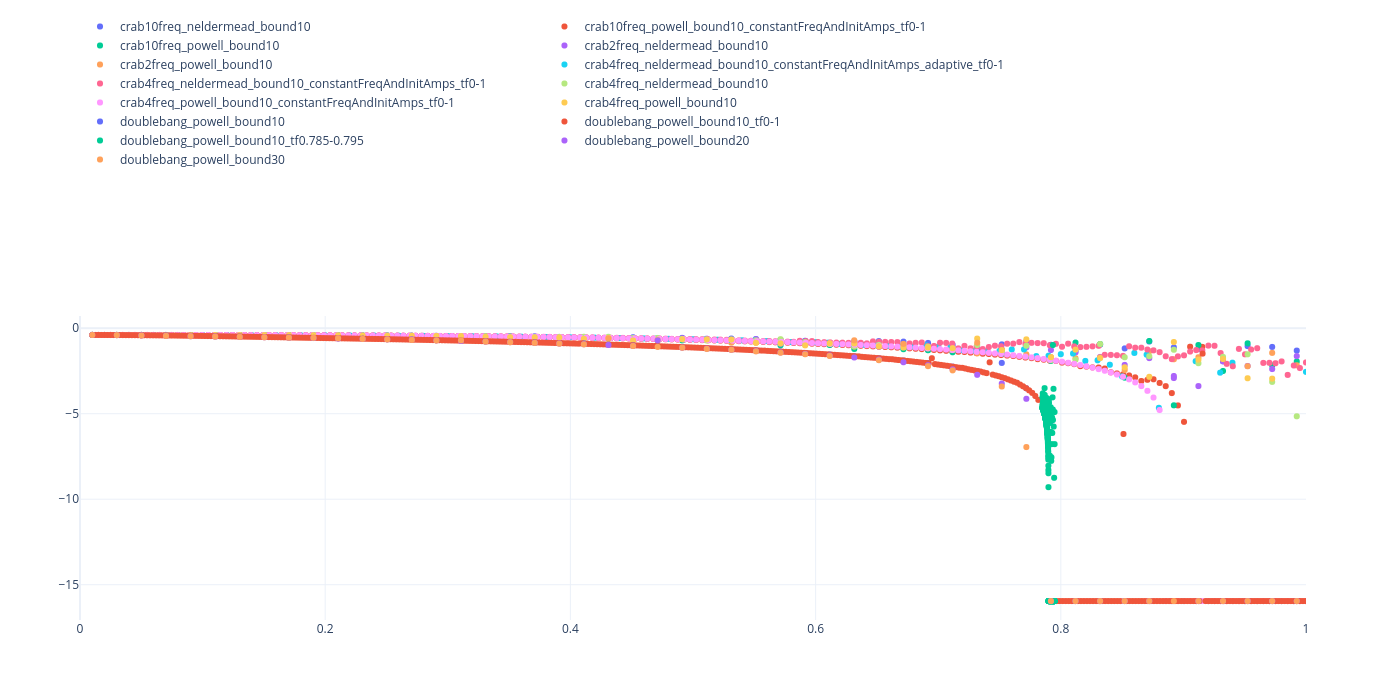

In [475]:
def _():
    datafiles = !ls ./results/lz_optimizations_20200507/*.csv
    fig = go.Figure()
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        df['fid'][df['fid'] >= 1] = 1 - 1e-16
        fig.add_trace(go.Scatter(
            x=df['tf'], y=np.log10(1 - df['fid']),
            mode='markers', name=os.path.split(file)[-1][3:-4]))
    fig.update_xaxes(range=[0, 1])
    fig.update_layout(legend=dict(x=0, y=2), width=900, height=700, legend_orientation='h')
    fig.show()
_()

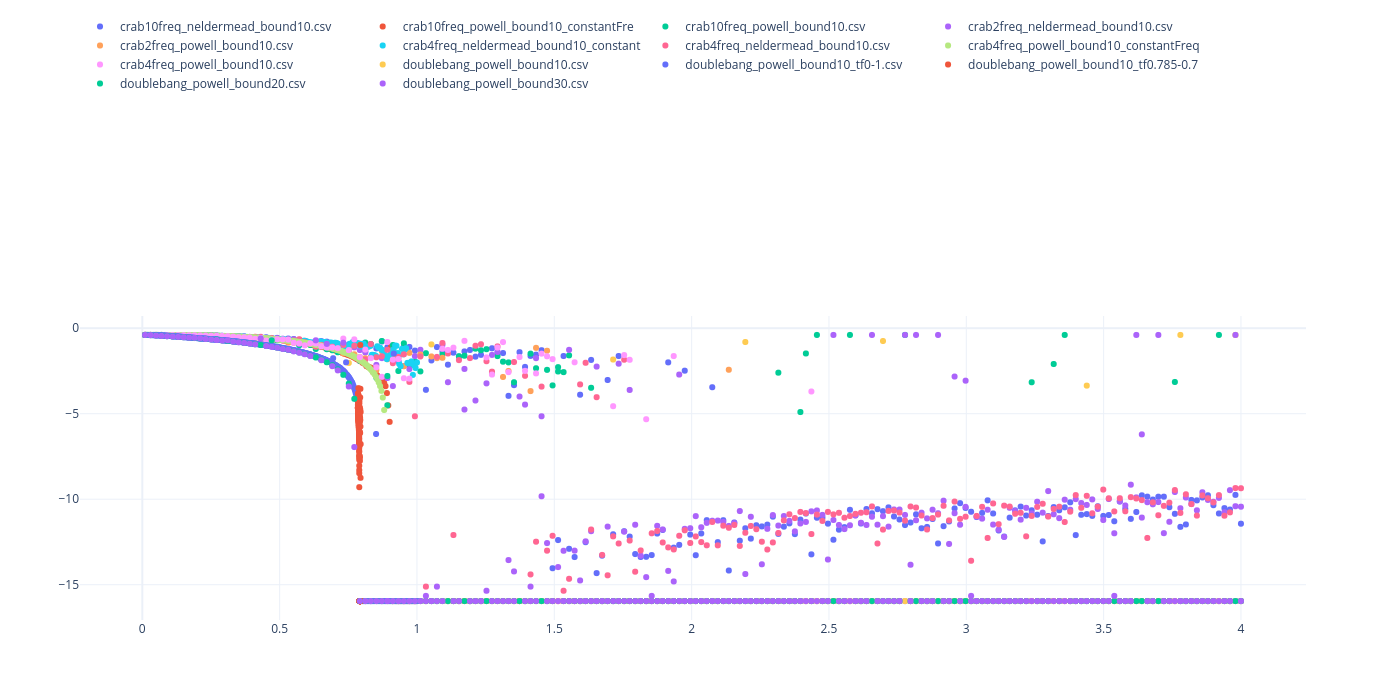

In [208]:
def _():
    datafiles = !ls ./results/lz_optimizations_20200507/*.csv
    fig = go.Figure()
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        df['fid'][df['fid'] >= 1] = 1 - 1e-16
        # plot
        fig.add_trace(go.Scatter(
            x=df['tf'], y=np.log10(1 - df['fid']),
            mode='markers', name=os.path.split(file)[-1][3:40]
        ))
    fig.update_layout(legend=dict(x=0, y=2), width=900, height=700, legend_orientation='h')
    fig.show()
    # plotly.offline.iplot(fig)
_()

## Rerun DB optimisations for single points

In [163]:
def _():
    tf = 0.9
    def optimize_with_initial_values(initial_values):
        hamiltonian = lz_model.LZModel(omega_0=1)
        # determine protocol and constraints
        protocol = protocol_ansatz.DoubleBangProtocolAnsatz()
        protocol.constrain_intensities([-10, 10])
        hamiltonian.td_protocol = protocol
        # optimize parameters
        results = optimization.optimize_model_parameters(
            hamiltonian=hamiltonian,
            initial_state=utils.ground_state(hamiltonian.hamiltonian(-5)),
            target_state=utils.ground_state(hamiltonian.hamiltonian(0)), 
            tlist=tf,
            initial_parameters=initial_values,
            optimization_method='powell'
        )
        return results
    results = optimize_with_initial_values([0, tf / 2, 0])
    print('Fidelity: {}'.format((1 - results.fun)**2))
    loginfidelities = np.log10(1 - (1 - results.fun)**2)
    print('Log Inf: {}'.format(loginfidelities))
    print(results)
_()

Fidelity: 1.0000000000000004
Log Inf: nan
    data: {'initial_pars': [0, 0.45, 0]}
   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 1.31566675e-01, -6.56908574e-03,  0.00000000e+00],
       [-5.19583239e-11,  2.47407289e-11, -1.15951733e-14]])
     fun: -2.220446049250313e-16
 message: 'Optimization terminated successfully.'
    nfev: 764
     nit: 11
  status: 0
 success: True
       x: array([ -0.49840725,   0.85804389, -10.        ])


<ipython-input-163-bf57023f1cc8>:21: RuntimeWarning:

invalid value encountered in log10



Optimise at the same $t_f$ multiple time, to probe the variation in the optimised fidelities:

[0.92900311 0.9348166  0.99993569 0.99993469 0.9999325  0.93187067
 0.99993566 0.99981886 0.99990314 0.99993569 0.99810732 0.99993569
 0.99993564 0.93012577 0.99993569 0.93493352 0.99993194 0.99991115
 0.87927911 0.99993569]


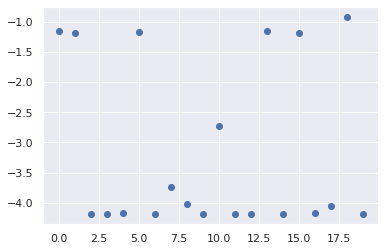

In [93]:
def _():
    tf = 0.78165
    def optimize_with_initial_values(initial_values):
        hamiltonian = lz_model.LZModel(omega_0=1)
        # determine protocol and constraints
        protocol = protocol_ansatz.DoubleBangProtocolAnsatz()
        protocol.constrain_intensities([-10, 10])
        hamiltonian.td_protocol = protocol
        # optimize parameters
        results = optimization.optimize_model_parameters(
            hamiltonian=hamiltonian,
            initial_state=utils.ground_state(hamiltonian.hamiltonian(-5)),
            target_state=utils.ground_state(hamiltonian.hamiltonian(0)), 
            tlist=tf,
            initial_parameters=initial_values,
            optimization_method='powell'
        )
        return results.fun
    random_vals = 10 * np.random.random((20, 2)) - 5  # random values in [-1, 1]
    initial_values = [[vals[0], tf / 2, vals[1]] for vals in random_vals]
    cost_outs = np.zeros(shape=len(initial_values))
    for idx, initial_value in enumerate(initial_values):
        cost_outs[idx] = optimize_with_initial_values(initial_value)
    print((1 - cost_outs)**2)
    loginfidelities = np.log10(1 - (1 - cost_outs)**2)
    plt.plot(loginfidelities, 'o')
_()

## CRAB optimisation for single points

We find that the powell method works significantly better in the case of LZ. With Nelder-Mead we almost never get to unit fidelities, whereas powell often does:

In [191]:
def optimize_LZ_CRAB_single_tf(tf, num_frequencies, init_frequencies, init_amps,
                               amps_constraints, height_constraints,
                               optimization_method, optimization_options):
    """Run optimization to go from gs of X-5Z to gs of X via CRAB."""
    hamiltonian = lz_model.LZModel(omega_0=1.)
    # define CRAB protocol ansatz
    protocol = protocol_ansatz.CRABProtocolAnsatz(num_frequencies=num_frequencies)
    # set frequencies
    protocol.generate_rnd_frequencies_each_tf = False
    for idx in range(num_frequencies):
        protocol.hyperpars['nuk' + str(idx + 1)] = init_frequencies[idx]
    # set rest of hyperparameters
    protocol.fill_hyperpar_value(y0=-5, y1=0)
    protocol.constrain_all_amplitudes(amps_constraints)
    protocol.set_total_height_constraints(height_constraints)
    hamiltonian.td_protocol = protocol
    # optimize parameters
    results = optimization.optimize_model_parameters(
        hamiltonian=hamiltonian,
        initial_state=utils.ground_state(hamiltonian.hamiltonian(-5)),
        target_state=utils.ground_state(hamiltonian.hamiltonian(0)), 
        tlist=tf,
        initial_parameters=init_amps,
        optimization_method=optimization_method,
        optimization_options=optimization_options
    )
    fidelity = (1 - results.fun)**2
    results.fidelity = fidelity
    return results

Powell gets us to numerical precision with 4 frequencies:

In [197]:
results = optimize_LZ_CRAB_single_tf(
    tf=0.9, num_frequencies=4, init_frequencies=np.zeros(shape=4), init_amps=np.zeros(shape=8),
    amps_constraints=[-200, 200], height_constraints=[-10, 10],
    optimization_method='powell', optimization_options=dict(maxiter=1e4, maxfev=1e4)
)
del results['direc']
results

     data: {'initial_pars': array([0., 0., 0., 0., 0., 0., 0., 0.])}
 fidelity: 1.0000000000000004
      fun: -2.220446049250313e-16
  message: 'Optimization terminated successfully.'
     nfev: 845
      nit: 6
   status: 0
  success: True
        x: array([169.82880815, 186.418668  , 132.12720513,  71.34801676,
       -34.14531231,  55.26845673,  74.08111401,  34.73395446])

Nelder-mead, not really:

In [199]:
results = optimize_LZ_CRAB_single_tf(
    tf=0.9, num_frequencies=4, init_frequencies=np.zeros(shape=4), init_amps=np.zeros(shape=8),
    amps_constraints=[-200, 200], height_constraints=[-10, 10],
    optimization_method='nelder-mead', optimization_options=dict(maxiter=1e4, maxfev=1e4)
)
del results['final_simplex']
results

          data: {'initial_pars': array([0., 0., 0., 0., 0., 0., 0., 0.])}
      fidelity: 0.9903278666158775
 final_simplex: (array([[ 136.77543816,   94.16810343,   -5.97651093, -104.58454876,
         -36.92129152,   26.04660893,    7.61782286,  -94.4160741 ],
       [ 136.77541067,   94.16807172,   -5.97643595, -104.58450387,
         -36.92130311,   26.04663262,    7.61787768,  -94.41614567],
       [ 136.77543222,   94.16805005,   -5.97643918, -104.58450415,
         -36.92129254,   26.04665442,    7.61776563,  -94.41610218],
       [ 136.77539167,   94.16804731,   -5.97645188, -104.58448923,
         -36.92128427,   26.04662897,    7.61782117,  -94.41609231],
       [ 136.77543663,   94.16810961,   -5.97648944, -104.58454924,
         -36.92129015,   26.04660889,    7.61787298,  -94.41612125],
       [ 136.77539013,   94.16806961,   -5.97649652, -104.58450117,
         -36.92130573,   26.04660951,    7.61783224,  -94.41604681],
       [ 136.77541805,   94.16806504,   -5.97646132,

In [209]:
results = optimize_LZ_CRAB_single_tf(
    tf=0.9, num_frequencies=4, init_frequencies=np.zeros(shape=4), init_amps=np.zeros(shape=8),
    amps_constraints=[-200, 200], height_constraints=[-10, 10],
    optimization_method='nelder-mead',
    optimization_options=dict(maxiter=1e4, maxfev=1e4, disp=True))
del results['final_simplex']
results

     data: {'initial_pars': array([0., 0., 0., 0., 0., 0., 0., 0.])}
 fidelity: 0.9903278666158775
      fun: 0.0048478173586326
  message: 'Optimization terminated successfully.'
     nfev: 2810
      nit: 1866
   status: 0
  success: True
        x: array([ 136.77543816,   94.16810343,   -5.97651093, -104.58454876,
        -36.92129152,   26.04660893,    7.61782286,  -94.4160741 ])

Nelder-Mead, $4$ frequencies. Does incresing the required precision help?

In [211]:
results = optimize_LZ_CRAB_single_tf(
    tf=0.9, num_frequencies=4, init_frequencies=np.zeros(shape=4), init_amps=np.zeros(shape=8),
    amps_constraints=[-200, 200], height_constraints=[-10, 10],
    optimization_method='nelder-mead',
    optimization_options=dict(maxiter=1e4, maxfev=1e4, xatol=1e-8, fatol=1e-8, disp=True))
del results['final_simplex']
results

Optimization terminated successfully.
         Current function value: 0.003710
         Iterations: 2665
         Function evaluations: 4081


     data: {'initial_pars': array([0., 0., 0., 0., 0., 0., 0., 0.])}
 fidelity: 0.9925942691225093
      fun: 0.003709746548472337
  message: 'Optimization terminated successfully.'
     nfev: 4081
      nit: 2665
   status: 0
  success: True
        x: array([ 149.82360047,  115.84004058,  -49.42883186, -107.31319578,
        -36.2588099 ,   71.31956796,   39.21809097, -114.25531512])

***Nelder-Mead, $4$ frequencies, higher precision and adaptive strategy***, works (but it takes $\sim6$ minutes to get the result!):

In [473]:
results = optimize_LZ_CRAB_single_tf(
    tf=0.89, num_frequencies=4, init_frequencies=np.zeros(shape=4), init_amps=np.zeros(shape=8),
    amps_constraints=[-200, 200], height_constraints=[-10, 10],
    optimization_method='nelder-mead',
    optimization_options=dict(maxiter=1e4, maxfev=1e4,
                              xatol=1e-8, fatol=1e-8,
                              disp=True, adaptive=True))
del results['final_simplex']
results

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 4383
         Function evaluations: 7818


     data: {'initial_pars': array([0., 0., 0., 0., 0., 0., 0., 0.])}
 fidelity: 1.0000000000000004
      fun: -2.220446049250313e-16
  message: 'Optimization terminated successfully.'
     nfev: 7818
      nit: 4383
   status: 0
  success: True
        x: array([192.85905549, 198.21325356,  85.23192274,  37.95561183,
       -32.41855735,  95.95289573, 108.94415586,  44.40210952])

In [212]:
results = optimize_LZ_CRAB_single_tf(
    tf=0.9, num_frequencies=4, init_frequencies=np.zeros(shape=4), init_amps=np.zeros(shape=8),
    amps_constraints=[-200, 200], height_constraints=[-10, 10],
    optimization_method='nelder-mead',
    optimization_options=dict(maxiter=1e4, maxfev=1e4,
                              xatol=1e-8, fatol=1e-8,
                              disp=True, adaptive=True))
del results['final_simplex']
results

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 4287
         Function evaluations: 7724


     data: {'initial_pars': array([0., 0., 0., 0., 0., 0., 0., 0.])}
 fidelity: 1.0000000000000004
      fun: -2.220446049250313e-16
  message: 'Optimization terminated successfully.'
     nfev: 7724
      nit: 4287
   status: 0
  success: True
        x: array([187.74154547, 193.47940196, 118.60467308,  33.27669964,
       -31.47184871,  77.75042722,  66.82638555,  88.19803775])

Powell with $10$ frequencies:

In [201]:
results = optimize_LZ_CRAB_single_tf(
    tf=0.9, num_frequencies=10, init_frequencies=np.zeros(shape=20), init_amps=np.zeros(shape=20),
    amps_constraints=[-200, 200], height_constraints=[-10, 10],
    optimization_method='powell', optimization_options=dict(maxiter=1e4, maxfev=1e4)
)
del results['direc']
results

     data: {'initial_pars': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])}
 fidelity: 0.9999979788833175
      fun: 1.0105588518216635e-06
  message: 'Optimization terminated successfully.'
     nfev: 9458
      nit: 15
   status: 0
  success: True
        x: array([161.60268597, 165.39765606,  91.81013486,  81.77598199,
       100.43268714,  76.18166457,  62.37207675,  87.35871869,
        84.1746781 ,  62.77105455, -33.1973816 ,  47.72431703,
        25.26985769, -42.16292192, -46.66384998, -51.79648025,
       -71.34073586, -45.88434155, -36.02685194,  -9.92705964])

Nelder-Mead with $10$ frequencies:

In [202]:
results = optimize_LZ_CRAB_single_tf(
    tf=0.9, num_frequencies=10, init_frequencies=np.zeros(shape=10), init_amps=np.zeros(shape=20),
    amps_constraints=[-200, 200], height_constraints=[-10, 10],
    optimization_method='nelder-mead', optimization_options=dict(maxiter=1e4, maxfev=1e4)
)
del results['final_simplex']
results

     data: {'initial_pars': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])}
 fidelity: 0.9329132800815739
      fun: 0.03412563959820636
  message: 'Maximum number of function evaluations has been exceeded.'
     nfev: 10000
      nit: 7508
   status: 1
  success: False
        x: array([ 72.35457184, -28.55226856,   9.6320961 , -26.37853924,
        14.10939471,  11.12356567,  16.00648344,  -6.18867384,
       -21.72351325,  42.91430906, -43.12476853, -24.24196682,
         1.69290862, -54.28930547,   8.14706958, -38.53850122,
        17.55059532, 109.77331052,  11.2337566 , -74.8830711 ])

## Generate plots for paper

### Downsampling data

In [227]:
def downsample_twocolumn_array(table, new_times_grid):
    """Assumes the time steps to be all equal"""
    dt = new_times_grid[1] - new_times_grid[0]
    times = table[:, 0]
    fids = table[:, 1]
    new_table = []
    for t in new_times_grid:
        indices = np.argwhere((times >= t - dt / 2) & (times <= t + dt / 2))
        if indices.shape[0] == 0:
            continue
        best_fid_idx = np.argwhere(fids[indices] == fids[indices].max())[0, 0]
        new_table.append(table[indices[best_fid_idx]][0])
    return np.asarray(new_table)

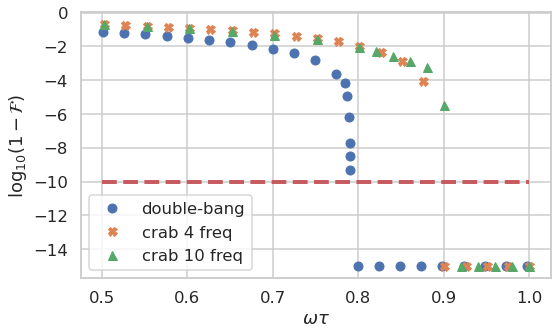

In [486]:
def _():
    sns.set_style('whitegrid')
    sns.set_context("talk")
    # load crab4freq data
    path_4freq = './results/lz_optimizations_20200507/lz_crab4freq_powell_bound10_constantFreqAndInitAmps_tf0-1.csv'
    df_4freq = pd.read_csv(path_4freq)[['tf', 'fid']]
    df_4freq = df_4freq[(df_4freq['tf'] > 0.5)]
    df_4freq.loc[df_4freq['fid'] >= 1, 'fid'] = 1 - 1e-15
    df_4freq['fid'] = np.log10(1 - df_4freq['fid'])
    df_4freq = df_4freq[::5]
    # load doublebang data
    path_4freq = './results/lz_optimizations_20200507/lz_doublebang_powell_bound10_tf0-1.csv'
    df_db = pd.read_csv(path_4freq)[['tf', 'fid']]
    df_db = df_db[(df_db['tf'] > 0.5)]
    df_db.loc[df_db['fid'] >= 1, 'fid'] = 1 - 1e-15
    df_db['fid'] = np.log10(1 - df_db['fid'])
    foo = df_db[(df_db['tf'] > 0.782) & (df_db['tf'] < 0.79)]
    df_db = df_db[::10]
    df_db = pd.concat([df_db, foo], axis=0)
    # load extra doublebang data
    path_4freqextra = './results/lz_optimizations_20200507/lz_doublebang_powell_bound10_tf0.785-0.795.csv'
    df_dbe = pd.read_csv(path_4freqextra)[['tf', 'fid']]
    df_dbe = df_dbe[(df_dbe['tf'] > 0.7898) & (df_dbe['tf'] < 0.78996)]
    df_dbe['fid'] = np.log10(1 - df_dbe['fid'])
    df_dbe = df_dbe.drop([193, 194, 195])
    df_db = pd.concat([df_db, df_dbe], ignore_index=True)
    # load crab10freq data
    path_10freq = './results/lz_optimizations_20200507/lz_crab10freq_powell_bound10_constantFreqAndInitAmps_tf0-1.csv'
    df_10freq = pd.read_csv(path_10freq)[['tf', 'fid']]
    df_10freq = pd.concat((
        df_10freq[(df_10freq['tf'] > 0.5) & (df_10freq['tf'] < 0.8)][::10],
        df_10freq[df_10freq['tf'] > 0.8][::4]
    ), ignore_index=True)
    # df_10freq = df_10freq.drop(df_10freq[df_10freq['tf'] < 0.8][::2].index)
    df_10freq.loc[df_10freq['fid'] >= 1, 'fid'] = 1 - 1e-15
    df_10freq['fid'] = np.log10(1 - df_10freq['fid'])
    # put data together
    # df = pd.concat([df_db, df_dbe, df_4freq], axis=0, ignore_index=True)
    # create plot
    fig, ax = plt.subplots(1, 1, figsize=(5 * scipy.constants.golden, 5))
    ax.plot(df_db['tf'], df_db['fid'], 'o', marker='o', label='double-bang')
    ax.plot(df_4freq['tf'], df_4freq['fid'], 'o', marker='X', label='crab 4 freq')
    ax.plot(df_10freq['tf'], df_10freq['fid'], 'o', marker='^', label='crab 10 freq', alpha=1)
    ax.legend()
#     markers = {'crab 4 freq': 'X', 'double-bang': 'o'}
#     sns.scatterplot(data=df, x='tf', y='fid', hue='source', style='source',
#                     markers=markers, ax=ax, s=130)
    # draw dashed threshold line
    xs_list = np.linspace(0.5, 1, 14)
    ax.plot([0.5, 1], [-10, -10], 'r--', linewidth=4, alpha=0.9)
    # ax.plot(xs_list, [-10] * len(xs_list), 'r--', linewidth=3, alpha=0.7)
    #
    ax.set(xlabel=r'$\omega\tau$', ylabel=r'$\log_{10}(1-\mathcal{F})$')
    # handles, labels = ax.get_legend_handles_labels()
    # ax.legend(handles=handles[1:], labels=labels[1:], loc=3)
    plt.tight_layout()
    fig.savefig('lz_toCriticalPoint_crabAndDB_strightThreshold.pdf')
_()

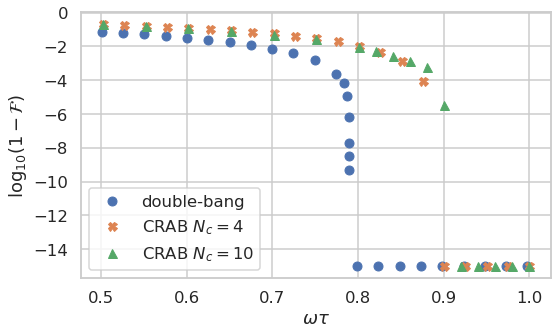

In [653]:
def _():
    sns.set_style('whitegrid')
    sns.set_context("talk")
    # load crab4freq data
    path_4freq = './results/lz_optimizations_20200507/lz_crab4freq_powell_bound10_constantFreqAndInitAmps_tf0-1.csv'
    df_4freq = pd.read_csv(path_4freq)[['tf', 'fid']]
    df_4freq = df_4freq[(df_4freq['tf'] > 0.5)]
    df_4freq.loc[df_4freq['fid'] >= 1, 'fid'] = 1 - 1e-15
    df_4freq['fid'] = np.log10(1 - df_4freq['fid'])
    df_4freq = df_4freq[::5]
    # load doublebang data
    path_4freq = './results/lz_optimizations_20200507/lz_doublebang_powell_bound10_tf0-1.csv'
    df_db = pd.read_csv(path_4freq)[['tf', 'fid']]
    df_db = df_db[(df_db['tf'] > 0.5)]
    df_db.loc[df_db['fid'] >= 1, 'fid'] = 1 - 1e-15
    df_db['fid'] = np.log10(1 - df_db['fid'])
    foo = df_db[(df_db['tf'] > 0.782) & (df_db['tf'] < 0.79)]
    df_db = df_db[::10]
    df_db = pd.concat([df_db, foo], axis=0)
    # load extra doublebang data
    path_4freqextra = './results/lz_optimizations_20200507/lz_doublebang_powell_bound10_tf0.785-0.795.csv'
    df_dbe = pd.read_csv(path_4freqextra)[['tf', 'fid']]
    df_dbe = df_dbe[(df_dbe['tf'] > 0.7898) & (df_dbe['tf'] < 0.78996)]
    df_dbe['fid'] = np.log10(1 - df_dbe['fid'])
    df_dbe = df_dbe.drop([193, 194, 195])
    df_db = pd.concat([df_db, df_dbe], ignore_index=True)
    # load crab10freq data
    path_10freq = './results/lz_optimizations_20200507/lz_crab10freq_powell_bound10_constantFreqAndInitAmps_tf0-1.csv'
    df_10freq = pd.read_csv(path_10freq)[['tf', 'fid']]
    df_10freq = pd.concat((
        df_10freq[(df_10freq['tf'] > 0.5) & (df_10freq['tf'] < 0.8)][::10],
        df_10freq[df_10freq['tf'] > 0.8][::4]
    ), ignore_index=True)
    # df_10freq = df_10freq.drop(df_10freq[df_10freq['tf'] < 0.8][::2].index)
    df_10freq.loc[df_10freq['fid'] >= 1, 'fid'] = 1 - 1e-15
    df_10freq['fid'] = np.log10(1 - df_10freq['fid'])
    # put data together
    # df = pd.concat([df_db, df_dbe, df_4freq], axis=0, ignore_index=True)
    # create plot
    fig, ax = plt.subplots(1, 1, figsize=(5 * scipy.constants.golden, 5))
    ax.plot(df_db['tf'], df_db['fid'], 'o', marker='o', label='double-bang')
    ax.plot(df_4freq['tf'], df_4freq['fid'], 'o', marker='X', label=r'CRAB $N_c=4$')
    ax.plot(df_10freq['tf'], df_10freq['fid'], 'o', marker='^', label=r'CRAB $N_c=10$', alpha=1)
    ax.legend()
    #
    ax.set(xlabel=r'$\omega\tau$', ylabel=r'$\log_{10}(1-\mathcal{F})$')
    # handles, labels = ax.get_legend_handles_labels()
    # ax.legend(handles=handles[1:], labels=labels[1:], loc=3)
    plt.tight_layout()
    fig.savefig('lz_toCriticalPoint_crabAndDB_strightThreshold.pdf')
_()

The optimisation returns a bunch of fidelities which are greater than one. Are these really due to numerical precision? Let's verify this  by checking that they really only larger than 1 at the numerical threshold. We find that indeed they are in an interval $[1-\epsilon,1+\epsilon]$ with $\epsilon\sim 10^{-15}$.

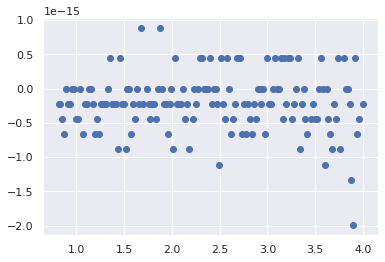

In [90]:
def _():
    # load data
    datafile = './results/lz_optimizations_20200507/lz_doublebang_powell_bound10.csv'
    df = pd.read_csv(datafile, index_col=0)
    
    df = df[df['fid'] > 1]
#     print(df)
#     return
    # try to manually recompute the fidelity
    tf_list = df['tf'].values
    fidelities = [recompute_fidelity_doublebang_manual_LZ(r[0], r[1], r[2], r[3])
                  for r in df[['t1', 'tf', 'y0', 'y1']].values]
    fidelities = np.asarray(fidelities)
    # fidelities = np.log10(fidelities)
    plt.plot(tf_list, fidelities - 1, 'bo')
    
_()

# Crossing critical point

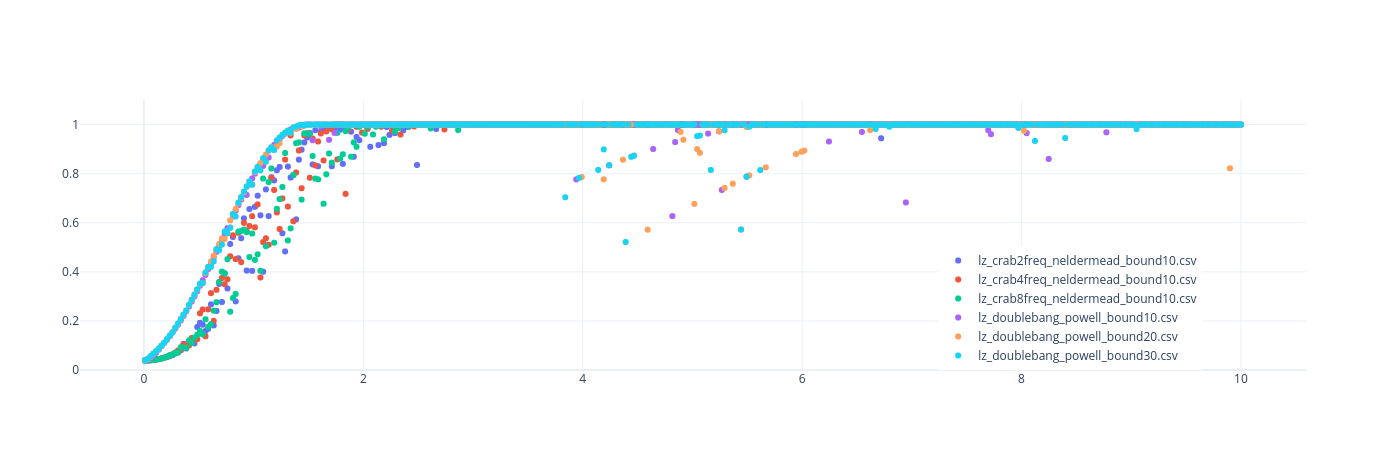

In [492]:
def _():
    # load data
    datafiles = !ls ./results/lz_optimizations_crossing_20190315/*.csv
    traces = []
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
#         df['fid'][df['fid'] >= 1] = 1 - 1e-16
#         print(np.log10(1 - df['fid']))
        # plot
        traces.append(go.Scatter(
            x=df['tf'], y=df['fid'],
            mode='markers', name=os.path.split(file)[-1]
        ))
    layout = go.Layout(legend=dict(x=.7, y=0), yaxis=dict(range=[0, 1.1]))
    plotly.offline.iplot(go.Figure(data=traces, layout=layout))
_()

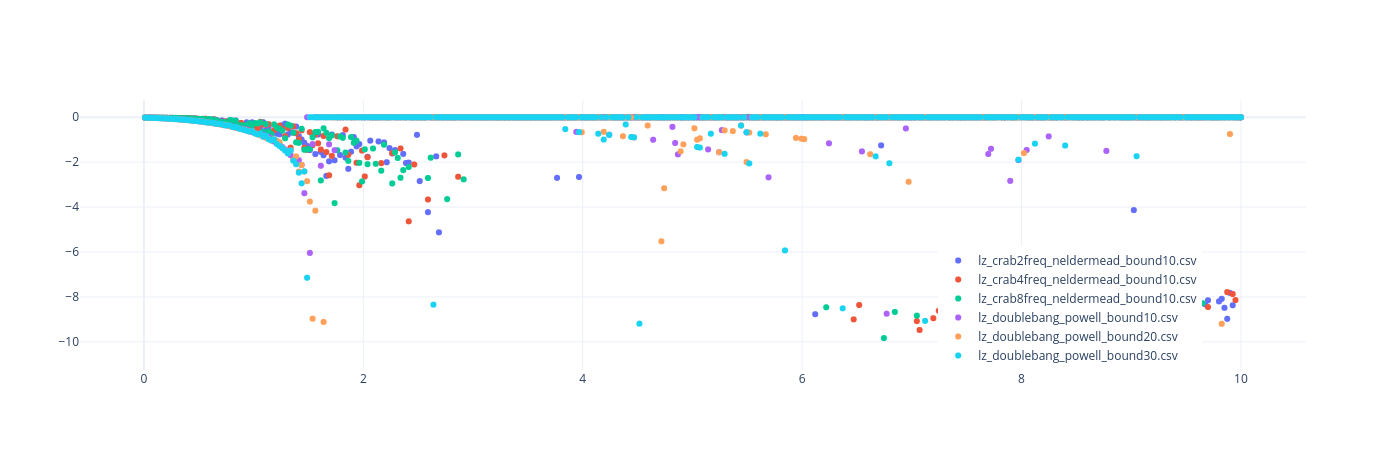

In [493]:
def _():
    # load data
    datafiles = !ls ./results/lz_optimizations_crossing_20190315/*.csv
    traces = []
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        df['fid'][df['fid'] >= 1] = 0 # 1 - 1e-16
#         print(np.log10(1 - df['fid']))
        # plot
        traces.append(go.Scatter(
            x=df['tf'], y=np.log10(1 - df['fid']),
            mode='markers', name=os.path.split(file)[-1]
        ))
    layout = go.Layout(legend=dict(x=.7, y=0))
    plotly.offline.iplot(go.Figure(data=traces, layout=layout))
_()

Let's look at the data generated with the improved version of the code

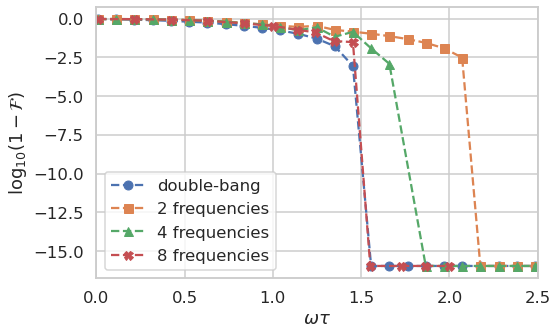

In [584]:
def _():
    basepath= './results/lz_optimizations_crossing_20200618'
    def load_from_file(filename, label):
        fullpath = os.path.join(basepath, filename)
        df = pd.read_csv(fullpath)[['tf', 'fid']]
        # df = df[df['tf'] <= 1.6]
        df['fid'][df['fid'] >= 1] = 1. - 1e-16
        df['fid'] = np.log10(1 - df['fid'])
        df['source'] = label
        return df
    df_freq2 = load_from_file('lz_crab2freq_neldermead_bound10.csv', '2 freq')
    df_freq4 = load_from_file('lz_crab4freq_neldermead_bound10.csv', '4 freq')
    df_freq4.drop([17], axis=0, inplace=True)
    df_freq8 = load_from_file('lz_crab8freq_neldermead_bound10.csv', '8 freq')
    df_freq8_2 = load_from_file('lz_crab8freq_neldermead_bound10_tf1-2.csv', '8 freq')
    df_db = load_from_file('lz_doublebang_powell_bound10.csv', 'double-bang')
    # df_b8.drop([12], axis=0, inplace=True)
    df = pd.concat([df_freq8, df_freq8_2], ignore_index=True)[['tf', 'fid']].sort_values(by='tf')
    df = df.iloc[[0, 2, 4, 6, 8, 10, 15, 19, 23, 28, 31, 38, 43, 49]]
    # create plot
    sns.set_style('whitegrid')
    sns.set_context("talk")
    fig, ax = plt.subplots(1, 1, figsize=(5 * scipy.constants.golden, 5))
    ax.set_xlim([0, 2.5])
    ax.plot(df_db['tf'], df_db['fid'], '--o', marker='o', label='double-bang', markersize=9)
    ax.plot(df_freq2['tf'], df_freq2['fid'], '--o', marker='s', label='2 frequencies', markersize=9)
    ax.plot(df_freq4['tf'], df_freq4['fid'], '--o', marker='^', label='4 frequencies', markersize=9)
#     ax.plot(df_freq8['tf'], df_freq8['fid'], '--o', marker='X', label='8 freq', markersize=8)
    ax.plot(df['tf'], df['fid'], '--o', marker='X', label='8 frequencies', markersize=9)
    ax.legend()
    ax.set(xlabel=r'$\omega\tau$', ylabel=r'$\log_{10}(1-\mathcal{F})$')
#     # handles, labels = ax.get_legend_handles_labels()
#     # ax.legend(handles=handles[1:], labels=labels[1:], loc=1)
    plt.tight_layout()
    fig.savefig('lz_crossing_dbVsCrab.pdf')
_()

# CRAB variable endpoints

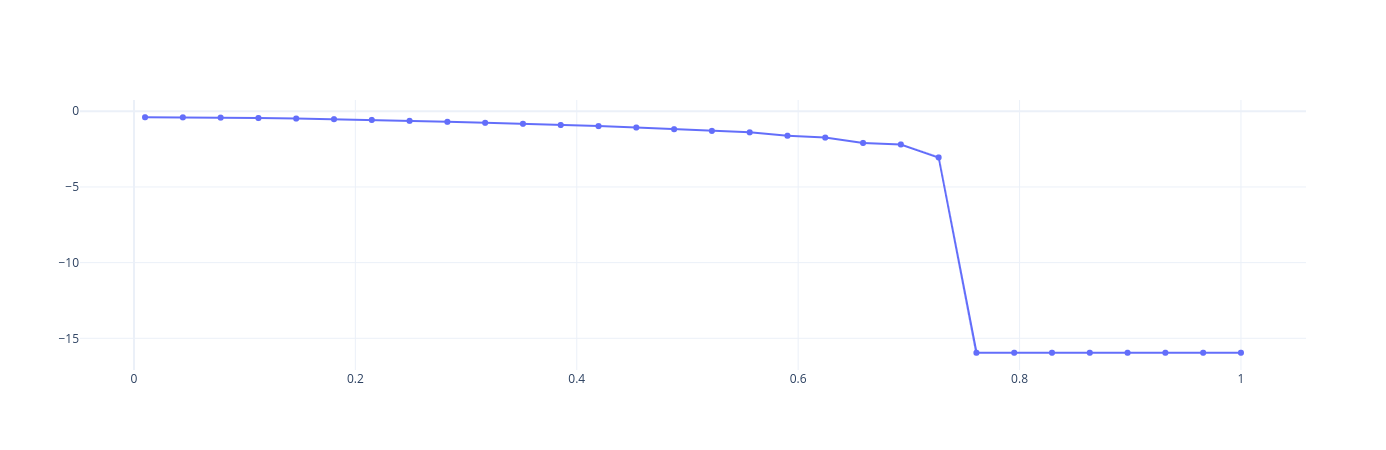

In [594]:
def _():
    # load data
    datafiles = !ls ./results/lz_optimizations_crabVariableEndPoints_20200623/*.csv
    fig = go.Figure()
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        df['fid'][df['fid'] >= 1] = 1 - 1e-16
        fig.add_trace(go.Scatter(
            x=df['tf'], y=np.log10(1 - df['fid']),
            mode='lines+markers', name=os.path.split(file)[-1][4:-4]
        ))
    # fig.update_layout(legend=dict(x=0.7, y=0, font=dict(size=10)))
    fig.show()
_()

In [648]:
def _():
    num_frequencies = 4
    hamiltonian = lz_model.LZModel(omega_0=1.)
    protocol = protocol_ansatz.CRABVariableEndpointsProtocolAnsatz(num_frequencies)
    protocol.generate_rnd_frequencies_each_tf = False
    for idx in range(num_frequencies):
        protocol.hyperpars['nuk' + str(idx + 1)] = 0
    # set rest of hyperparameters
    # protocol.fill_hyperpar_value(y0=-5, y1=0)
    protocol.constrain_all_amplitudes([-200, 200])
    protocol.set_total_height_constraints([-10, 10])
    hamiltonian.td_protocol = protocol
    # optimize parameters
    results = optimization.optimize_model_parameters(
        hamiltonian=hamiltonian,
        initial_state=utils.ground_state(hamiltonian.hamiltonian(-5)),
        target_state=utils.ground_state(hamiltonian.hamiltonian(0)), 
        tlist=0.76,
        initial_parameters=[0] * (2 * num_frequencies + 2),
        optimization_method='Nelder-Mead',
        optimization_options=dict(maxiter=1e5, maxfev=1e5, xatol=1e-8, fatol=1e-8, adaptive=True)
    )
    fidelity = (1 - results.fun)**2
    results.fidelity = fidelity
    return results
results = _()
del results.final_simplex
print(results)
[results.fidelity, np.log10(1 - results.fidelity)]

     data: {'initial_pars': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
 fidelity: 1.0000000000000004
      fun: -2.220446049250313e-16
  message: 'Optimization terminated successfully.'
     nfev: 12614
      nit: 7097
   status: 0
  success: True
        x: array([-108.93335751,  126.20645218,  -91.84772736,   36.36276889,
         82.70098234,  -22.05456293,  -76.38708061,   89.57686652,
          5.92029118,   -9.94263867])


<ipython-input-648-782ebd209319>:29: RuntimeWarning:

invalid value encountered in log10



[1.0000000000000004, nan]

In [649]:
def _():
    num_frequencies = 4
    hamiltonian = lz_model.LZModel(omega_0=1.)
    protocol = protocol_ansatz.CRABVariableEndpointsProtocolAnsatz(num_frequencies)
    protocol.generate_rnd_frequencies_each_tf = False
    for idx in range(num_frequencies):
        protocol.hyperpars['nuk' + str(idx + 1)] = 0
    # set rest of hyperparameters
    # protocol.fill_hyperpar_value(y0=-5, y1=0)
    protocol.constrain_all_amplitudes([-200, 200])
    protocol.set_total_height_constraints([-10, 10])
    hamiltonian.td_protocol = protocol
    # optimize parameters
    results = optimization.optimize_model_parameters(
        hamiltonian=hamiltonian,
        initial_state=utils.ground_state(hamiltonian.hamiltonian(-5)),
        target_state=utils.ground_state(hamiltonian.hamiltonian(0)), 
        tlist=0.74,
        initial_parameters=[0] * (2 * num_frequencies + 2),
        optimization_method='Nelder-Mead',
        optimization_options=dict(maxiter=1e5, maxfev=1e5, xatol=1e-8, fatol=1e-8, adaptive=True)
    )
    fidelity = (1 - results.fun)**2
    results.fidelity = fidelity
    return results
results = _()
del results.final_simplex
print(results)
[results.fidelity, np.log10(1 - results.fidelity)]

     data: {'initial_pars': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
 fidelity: 0.9998982266361082
      fun: 5.0887976739022456e-05
  message: 'Optimization terminated successfully.'
     nfev: 12781
      nit: 7405
   status: 0
  success: True
        x: array([  15.61729856,   31.28191435,   28.46639773,   71.2730306 ,
         -3.66816289, -154.92151562,  -14.70403351,  -66.99424889,
          6.52884931,   -6.41478796])


[0.9998982266361082, -3.9923658706086975]

In [650]:
def _():
    num_frequencies = 4
    hamiltonian = lz_model.LZModel(omega_0=1.)
    protocol = protocol_ansatz.CRABVariableEndpointsProtocolAnsatz(num_frequencies)
    protocol.generate_rnd_frequencies_each_tf = False
    for idx in range(num_frequencies):
        protocol.hyperpars['nuk' + str(idx + 1)] = 0
    # set rest of hyperparameters
    # protocol.fill_hyperpar_value(y0=-5, y1=0)
    protocol.constrain_all_amplitudes([-200, 200])
    protocol.set_total_height_constraints([-10, 10])
    hamiltonian.td_protocol = protocol
    # optimize parameters
    results = optimization.optimize_model_parameters(
        hamiltonian=hamiltonian,
        initial_state=utils.ground_state(hamiltonian.hamiltonian(-5)),
        target_state=utils.ground_state(hamiltonian.hamiltonian(0)), 
        tlist=0.75,
        initial_parameters=[0] * (2 * num_frequencies + 2),
        optimization_method='Nelder-Mead',
        optimization_options=dict(maxiter=1e5, maxfev=1e5, xatol=1e-8, fatol=1e-8, adaptive=True)
    )
    fidelity = (1 - results.fun)**2
    results.fidelity = fidelity
    return results
results = _()
del results.final_simplex
print(results)
[results.fidelity, np.log10(1 - results.fidelity)]

     data: {'initial_pars': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
 fidelity: 0.9999898465026219
      fun: 5.0767615757951745e-06
  message: 'Optimization terminated successfully.'
     nfev: 13981
      nit: 7904
   status: 0
  success: True
        x: array([-103.08243098,   92.60243074,  -45.20642839,   -1.47900392,
         29.51591731,  -28.35204696,  -85.80002237,   24.29815607,
          5.46885198,   -9.78686934])


[0.9999898465026219, -4.993384338993476]

In [631]:
def _():
    num_frequencies = 4
    hamiltonian = lz_model.LZModel(omega_0=1.)
    protocol = protocol_ansatz.CRABVariableEndpointsProtocolAnsatz(num_frequencies)
    protocol.generate_rnd_frequencies_each_tf = False
    for idx in range(num_frequencies):
        protocol.hyperpars['nuk' + str(idx + 1)] = 0
    # set rest of hyperparameters
    # protocol.fill_hyperpar_value(y0=-5, y1=0)
    protocol.constrain_all_amplitudes([-200, 200])
    protocol.set_total_height_constraints([-10, 10])
    hamiltonian.td_protocol = protocol
    # optimize parameters
    results = optimization.optimize_model_parameters(
        hamiltonian=hamiltonian,
        initial_state=utils.ground_state(hamiltonian.hamiltonian(-5)),
        target_state=utils.ground_state(hamiltonian.hamiltonian(0)), 
        tlist=0.77,
        initial_parameters=[0] * (2 * num_frequencies + 2),
        optimization_method='Nelder-Mead',
        optimization_options=dict()
    )
    fidelity = (1 - results.fun)**2
    results.fidelity = fidelity
    return results
results = _()
del results.final_simplex
print(results)
[results.fidelity, np.log10(1 - results.fidelity)]

     data: {'initial_pars': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
 fidelity: 0.9996233865192038
      fun: 0.00018832447345173975
  message: 'Maximum number of function evaluations has been exceeded.'
     nfev: 2000
      nit: 1389
   status: 1
  success: False
        x: array([ -5.65305203,  57.50065778,  74.30744664, -67.93848624,
       -36.83612852, -47.61742788,  15.59697437, -47.87142752,
         3.78041508,  -4.62393718])


[0.9996233865192038, -3.424104138566247]

In [623]:
def _():
    num_frequencies = 4
    hamiltonian = lz_model.LZModel(omega_0=1.)
    protocol = protocol_ansatz.CRABProtocolAnsatz(num_frequencies=num_frequencies)
    protocol.generate_rnd_frequencies_each_tf = False
    for idx in range(num_frequencies):
        protocol.hyperpars['nuk' + str(idx + 1)] = 0
    # set rest of hyperparameters
    protocol.fill_hyperpar_value(y0=-5, y1=0)
    protocol.constrain_all_amplitudes([-200, 200])
    protocol.set_total_height_constraints([-10, 10])
    hamiltonian.td_protocol = protocol
    # optimize parameters
    results = optimization.optimize_model_parameters(
        hamiltonian=hamiltonian,
        initial_state=utils.ground_state(hamiltonian.hamiltonian(-5)),
        target_state=utils.ground_state(hamiltonian.hamiltonian(0)), 
        tlist=1.,
        initial_parameters=[0] * (2 * num_frequencies),
        optimization_method='Nelder-Mead',
        optimization_options=dict(maxiter=1e5, maxfev=1e5, xatol=1e-8, fatol=1e-8, adaptive=True)
    )
    fidelity = (1 - results.fun)**2
    results.fidelity = fidelity
    return results
results = _()
del results.final_simplex
print(results)
[results.fidelity, np.log10(1 - results.fidelity)]

     data: {'initial_pars': [0, 0, 0, 0, 0, 0, 0, 0]}
 fidelity: 0.99721059558819
      fun: 0.0013956761618794111
  message: 'Optimization terminated successfully.'
     nfev: 7785
      nit: 4431
   status: 0
  success: True
        x: array([ 95.00846846,  46.6921117 ,  14.42742446,  11.40169155,
       -35.9459048 ,  14.23074063, -87.13855881, -87.80310172])


[0.99721059558819, -2.5544885165388798]

In [626]:
def _():
    num_frequencies = 4
    hamiltonian = lz_model.LZModel(omega_0=1.)
    protocol = protocol_ansatz.CRABProtocolAnsatz(num_frequencies=num_frequencies)
    protocol.generate_rnd_frequencies_each_tf = False
    for idx in range(num_frequencies):
        protocol.hyperpars['nuk' + str(idx + 1)] = 0
    # set rest of hyperparameters
    protocol.fill_hyperpar_value(y0=-5, y1=0)
    protocol.constrain_all_amplitudes([-200, 200])
    protocol.set_total_height_constraints([-10, 10])
    hamiltonian.td_protocol = protocol
    # optimize parameters
    results = optimization.optimize_model_parameters(
        hamiltonian=hamiltonian,
        initial_state=utils.ground_state(hamiltonian.hamiltonian(-5)),
        target_state=utils.ground_state(hamiltonian.hamiltonian(0)), 
        tlist=0.9,
        initial_parameters=[0] * (2 * num_frequencies),
        optimization_method='Nelder-Mead',
        optimization_options=dict()
    )
    fidelity = (1 - results.fun)**2
    results.fidelity = fidelity
    return results
results = _()
del results.final_simplex
print(results)
[results.fidelity, np.log10(1 - results.fidelity)]

     data: {'initial_pars': [0, 0, 0, 0, 0, 0, 0, 0]}
 fidelity: 0.9893075466604536
      fun: 0.0053605946573132
  message: 'Maximum number of function evaluations has been exceeded.'
     nfev: 1600
      nit: 1063
   status: 1
  success: False
        x: array([ 141.62278554,   94.95090634,   10.74677726, -105.05167908,
        -36.31477221,   31.88235176,   22.38748957, -122.23472253])


[0.9893075466604536, -1.9709226362707533]

Double-check the time required to get $10^{-16}$ infidelity with double-bang:

In [622]:
def _():
    """Run optimization to go from gs of X-5Z to gs of X via CRAB."""
    hamiltonian = lz_model.LZModel(omega_0=1.)
    protocol = protocol_ansatz.DoubleBangProtocolAnsatz()
    protocol.constrain_intensities([-10, 10])
    hamiltonian.td_protocol = protocol
    # optimize parameters
    results = optimization.optimize_model_parameters(
        hamiltonian=hamiltonian,
        initial_state=utils.ground_state(hamiltonian.hamiltonian(-5)),
        target_state=utils.ground_state(hamiltonian.hamiltonian(0)), 
        tlist=0.78996,
        initial_parameters=[0, .5, 0],
        optimization_method='Powell',
        optimization_options=dict()
    )
    fidelity = (1 - results.fun)**2
    results.fidelity = fidelity
    return results
results = _()
print(results)
[results.fidelity, np.log10(1 - results.fidelity)]

     data: {'initial_pars': [0, 0.5, 0]}
    direc: array([[-2.72647140e-02,  1.14428954e-03,  1.29332425e-03],
       [-5.49449893e-05,  2.32003226e-06, -3.47813538e-06],
       [-6.98228450e-04,  3.51581962e-05, -6.24425191e-04]])
 fidelity: 0.9999999999996187
      fun: 1.9062529332813938e-13
  message: 'Optimization terminated successfully.'
     nfev: 1450
      nit: 22
   status: 0
  success: True
        x: array([ 0.53263307,  0.6981203 , -9.99999997])


[0.9999999999996187, -12.418789479366106]

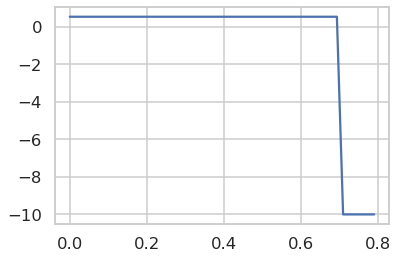

In [646]:
protocol = protocol_ansatz.DoubleBangProtocolAnsatz()
protocol.fill_hyperpar_value(tf=0.78996)
protocol.plot([ 0.53263307,  0.6981203 , -9.99999997])

In [638]:
def _():
    """Run optimization to go from gs of X-5Z to gs of X via CRAB."""
    hamiltonian = lz_model.LZModel(omega_0=1.)
    protocol = protocol_ansatz.TripleBangProtocolAnsatz()
    protocol.constrain_intensities([-10, 10])
    hamiltonian.td_protocol = protocol
    # optimize parameters
    results = optimization.optimize_model_parameters(
        hamiltonian=hamiltonian,
        initial_state=utils.ground_state(hamiltonian.hamiltonian(-5)),
        target_state=utils.ground_state(hamiltonian.hamiltonian(0)), 
        tlist=0.765,
        initial_parameters=[0.53, 0.53, -9.99, .1, .7],
        optimization_method='Powell',
        optimization_options=dict()
    )
    fidelity = (1 - results.fun)**2
    results.fidelity = fidelity
    return results
results = _()
print(results)
[results.fidelity, np.log10(1 - results.fidelity)]

     data: {'initial_pars': [0.53, 0.53, -9.99, 0.1, 0.7]}
    direc: array([[-6.30656469e-10,  6.22099561e-05, -5.98461269e-06,
         6.90543548e-05, -1.31925306e-05],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 1.99713888e-05, -7.87892821e-08,  8.45112718e-09,
         4.07563959e-15,  5.97007885e-12]])
 fidelity: 1.0000000000000004
      fun: -2.220446049250313e-16
  message: 'Optimization terminated successfully.'
     nfev: 1686
      nit: 14
   status: 0
  success: True
        x: array([ 9.99966526,  0.02138662, -9.99998825,  0.02527417,  0.69341996])


<ipython-input-638-cad0d89741cb>:22: RuntimeWarning:

invalid value encountered in log10



[1.0000000000000004, nan]

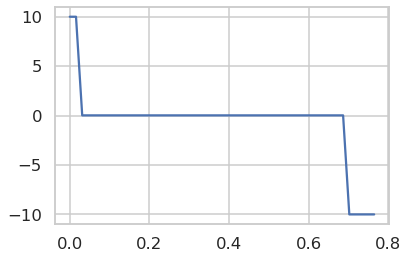

In [642]:
protocol = protocol_ansatz.TripleBangProtocolAnsatz()
protocol.fill_hyperpar_value(tf=0.765)
protocol.plot([ 9.99966526,  0.02138662, -9.99998825,  0.02527417,  0.69341996])

# Misc code snippets

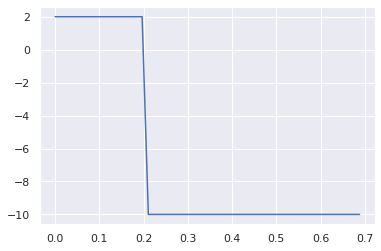

In [250]:
sns.set()
protocol = protocol_ansatz.DoubleBangProtocolAnsatz()
protocol.fill_hyperpar_value(tf=0.688)
protocol.plot([ 2,   0.2, -9.99999974])

double check the pulse shape

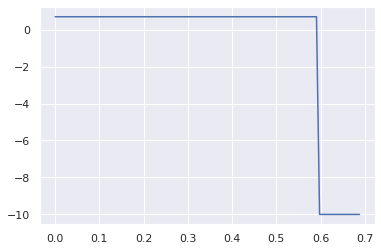

In [195]:
def _():
    times = np.linspace(0, 0.688, 100)
    fun = protocol.time_dependent_fun([ 0.6966497,   0.59609705, -9.99999974])
    ys = [fun(t) for t in times]
    plt.plot(times, ys)
_()

In [198]:
foo = lz_model.LZModel(omega_0=1, td_protocol=protocol)

In [199]:
foo.critical_ground_state()

AttributeError: 'function' object has no attribute 'eigenstates'

In [ ]:
def _():
    lmg_Hfree = lmg_model.LMG_free_term(num_spins=num_spins)
    lmg_Htarget = lmg_model.LMG_full_hamiltonian(num_spins=num_spins, g_value=2)
    psi_initial = ground_state(lmg_Hfree)
    psi_target = ground_state(lmg_Htarget)
    t1 = 5.2
    tf_list = np.linspace(8, 9, 60)
    fids = []
    bar = progressbar.ProgressBar()
    for tf in bar(tf_list):
        result = qutip.mesolve(H=lmg_model.LMG_full_hamiltonian(num_spins=num_spins, g_value=1.1),
                               rho0=psi_initial, tlist=np.linspace(0, t1, 40))
        result = qutip.mesolve(H=lmg_model.LMG_full_hamiltonian(num_spins=num_spins, g_value=1.5),
                               rho0=result.states[-1], tlist=np.linspace(0, tf - t1, 40))
        fids.append(qutip.fidelity(result.states[-1], psi_target)**2)
    plt.figure(); plt.plot(tf_list, fids, '-o')
_()

In [ ]:
protocol.evolve_state()

In [257]:
qutip.fidelity(
    lz_model.LZModel(omega_0=1).ground_state(-5),
    lz_model.LZModel(omega_0=1).ground_state(0)
)**2

0.5980580675690922

2019-03-14 17:07:51,983 [MainThread  ][DEBUG]  Initializing ProtocolAnsatz instance "crab"
2019-03-14 17:07:51,984 [MainThread  ][DEBUG]  Using 2 frequencies
2019-03-14 17:07:51,986 [MainThread  ][DEBUG]  Regenerated CRAB frequencies: nuk=[0.0133108  0.17020046]
2019-03-14 17:07:51,987 [MainThread  ][DEBUG]  Setting hyperparameter tf=1.0
2019-03-14 17:07:51,989 [MainThread  ][DEBUG]  Setting hyperparameter y0=-2
2019-03-14 17:07:51,990 [MainThread  ][DEBUG]  Setting hyperparameter y1=0
2019-03-14 17:07:51,991 [MainThread  ][DEBUG]  Setting hyperparameter nuk1=0.06945239
2019-03-14 17:07:51,991 [MainThread  ][DEBUG]  Setting hyperparameter nuk2=-0.07438579


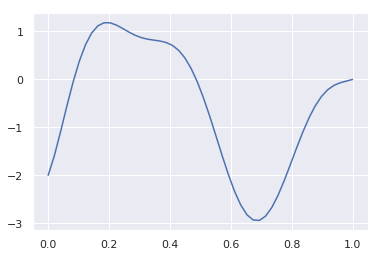

In [282]:
protocol = protocol_ansatz.CRABProtocolAnsatz(num_frequencies=2)
protocol.fill_hyperpar_value(tf=1.0)
protocol.fill_hyperpar_value(y0=-2, y1=0)
freqs = [ 0.06945239, -0.07438579]
protocol.fill_hyperpar_value(nuk1=freqs[0], nuk2=freqs[1])
protocol.plot([163.90725272 ,  0.70841171 , -0.7064373 ,  74.7643606 ])